# Testing Model Architectures

### Notable changes:
- Shape of model input images and resized images was changed to (368,656) to provide
further downsampling and upsampling to fix odd numbered down samples and upsamples causing errors when trying to concatenate layers.
- Model architecture now contains an additional upsample and two more down sampling layers

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


2023-05-02 14:39:23.712152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_keras_model(model_name):
    model = tf.keras.models.load_model(model_name)

    return model

def display(display_list):
  plt.figure(figsize=(28, 28))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

# Get's the largest value between the two model filter layers then
# outputs a mask where each pixel denotes our models prediciton for each pixel
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

## Code from new `util.py`

In [4]:
def preprocess(instance):
  # Potential dimmensionality reduction (consider different shapes):
  # input_image = tf.image.resize(datapoint['image'], (128, 128))

  # Resize each image from (720, 1280) -> (360, 640)
  resized = tf.image.resize(instance['image'], (384, 640))

  # Normalize the input to 0-1 range
  input_image = tf.cast(resized, tf.float32) / 255.0

  # Resize bitmask's:
  resized_bitmask = tf.image.resize(instance['label'], (384, 640))

  # Replace pixel values equal to 255 with 0, else 1
  # 255 pixel values arn't lane lines and other pixel
  # values are neglected since other subtasks of lane marking
  # are ignored.
  # bitmask_label = tf.where(resized_bitmask == 255, 1, 0) # Previus implementation
  bitmask_label = tf.where(resized_bitmask == 255, 0, 1) 
  
  print("preprocessing")

  return (input_image, bitmask_label)

# Loads a subset of the bdd100k dataset and returns it.
# The dataset contains "train", "validate", and "test" sections
def load_10k_data():

  # train, valid = tfds.load('bdd', split=['train[:1000]', 'test[:1000]'])

  # # NOTE THIS DIFFERES FROM ACTUAL PRPROCESSING IN MODEL TRAINING
  # # THE DIFFERENCES BEING THIS DOESN'T use .cache() AND HAS BATCH SIZE OF 1
  # train_set = train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
  # validate_set = valid.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
  
# Full implementation:
   # Retrieve custom tfds of BDD10k datatset
  dataset = tfds.load('bdd')
  train_set = dataset['train'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
  validate_set = dataset['test'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)

  test_set = dataset['validate'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
  
  return train_set, validate_set, test_set

## Code from new `model.py`

In [4]:
import tensorflow as tf
import numpy as np
# from tensorflow_examples.models.pix2pix import pix2pix

''' 
Code pulled from tensforflow_examples:
  - upsample()
  - InstanceNomalization
  
  link: https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py

'''
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def create_ResNetV2_model():
  base_model = tf.keras.applications.ResNet50V2(input_shape=[384, 640, 3], include_top=False)

  # Use the activations of these layers
  layer_names = [
    "conv1_conv",  # (192,320,64)
    "conv2_block1_3_conv", # (96, 160)
    "conv3_block3_1_conv", # (48, 80)
    "conv4_block1_1_conv", # (24, 40)
    "conv5_block1_1_conv", # (12,20)
  ]
  
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

  # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

  down_stack.trainable = False

  up_stack = [
    upsample(256, 3),
    upsample(128, 3),  
    upsample(64, 3),  
    upsample(32, 3),  
  ]

  return up_stack, down_stack

def resnet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[384, 640, 3])

  up_stack, down_stack = create_ResNetV2_model()

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    # print("up = ", up)
    x = up(x)
    # print("x = ", x)
    # print("skip = ", skip)

    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)
  

In [9]:
train_set, validate_set, test_set  =load_10k_data()

print(len(train_set))
print(len(validate_set))
print(len(test_set))

preprocessing
preprocessing
preprocessing
7000
2000
1000


In [8]:
train_set, validate_set = load_10k_data()

preprocessing
preprocessing
preprocessing


ValueError: too many values to unpack (expected 2)

In [18]:
untrained_model = resnet_model(output_channels=2)

untrained_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model `model_d10_full_conv` Testing

In [20]:
trained_model = load_keras_model("model_d10_full_conv")

1/1 [==============================] - 0s 379ms/step


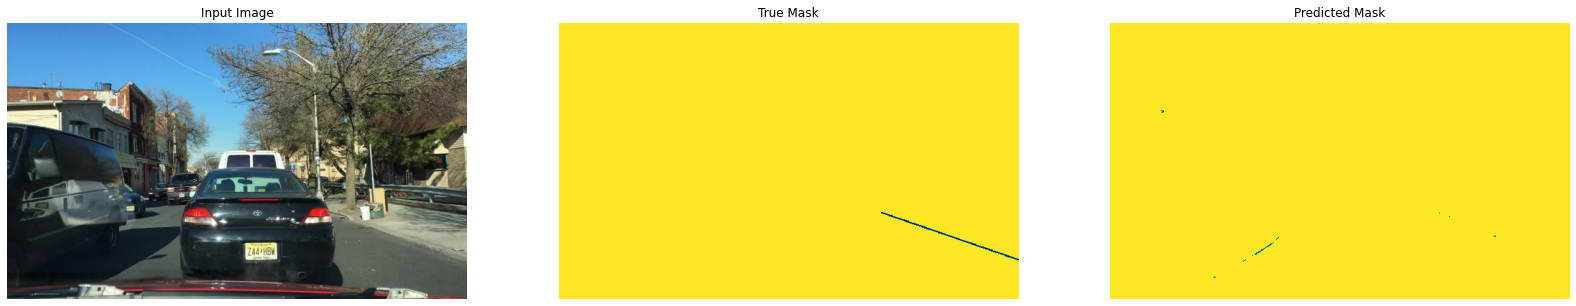

1/1 [==============================] - 0s 362ms/step


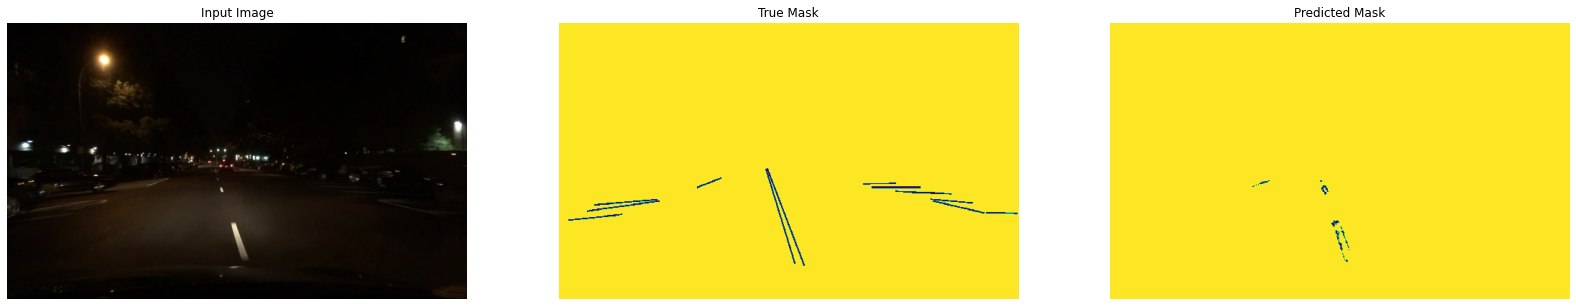

1/1 [==============================] - 0s 365ms/step


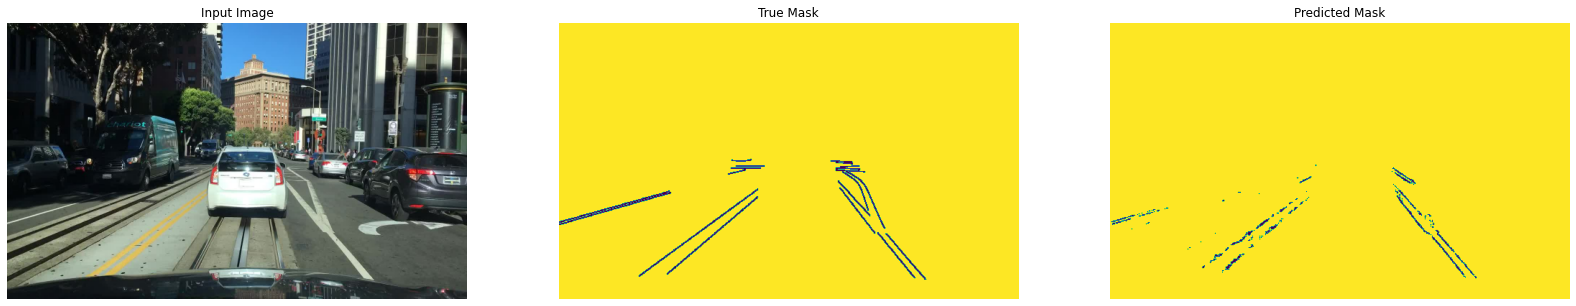

1/1 [==============================] - 0s 360ms/step


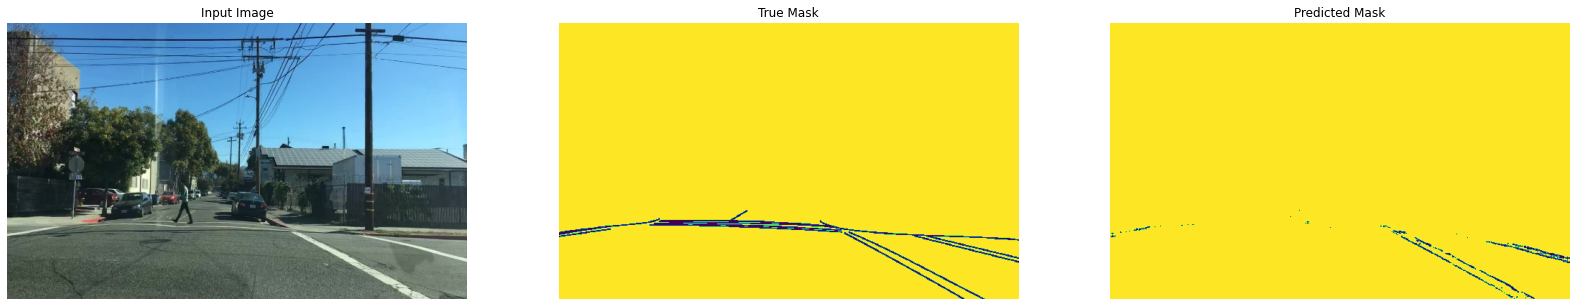

1/1 [==============================] - 0s 343ms/step


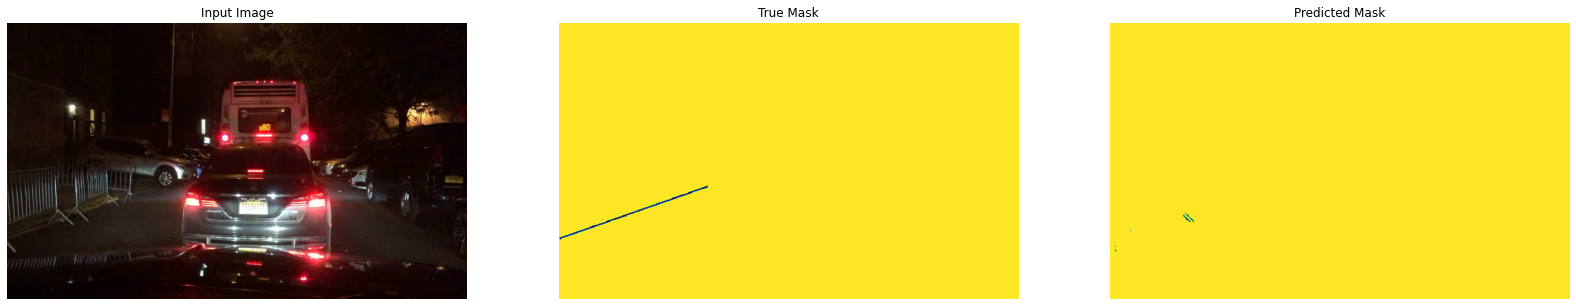

1/1 [==============================] - 0s 370ms/step


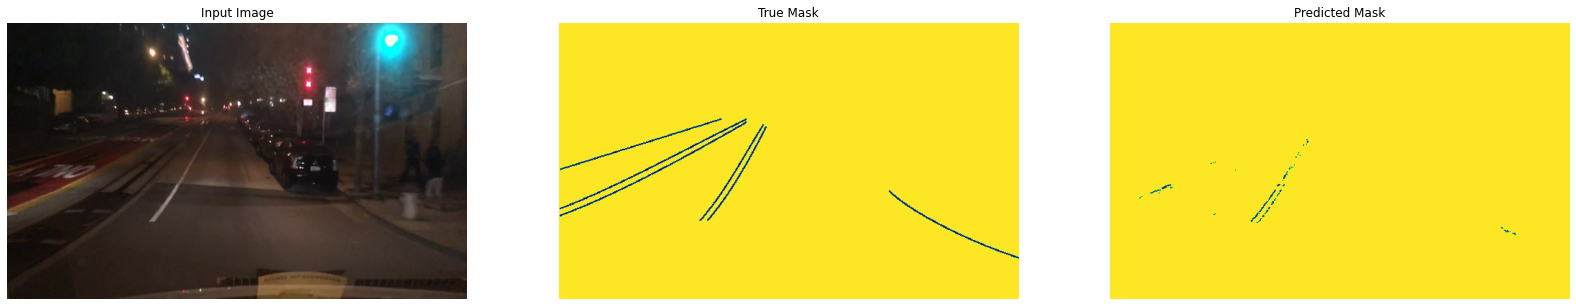

1/1 [==============================] - 0s 296ms/step


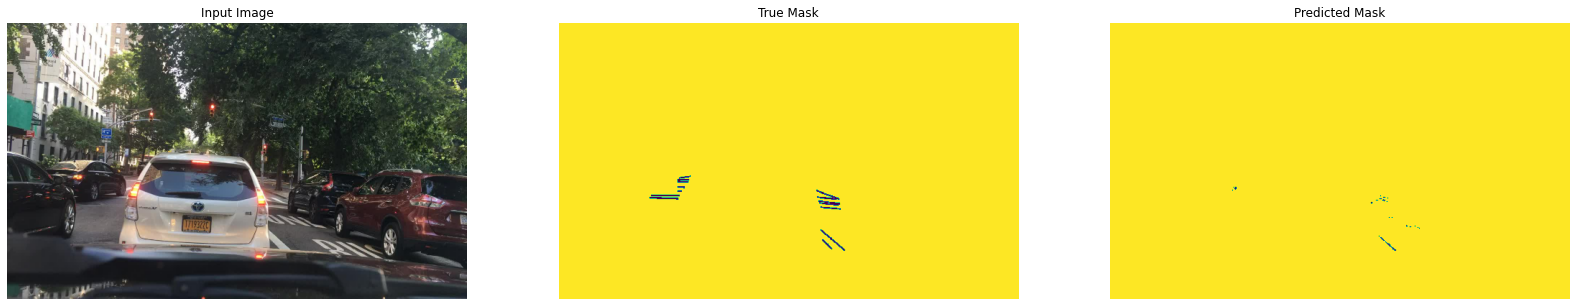

1/1 [==============================] - 0s 289ms/step


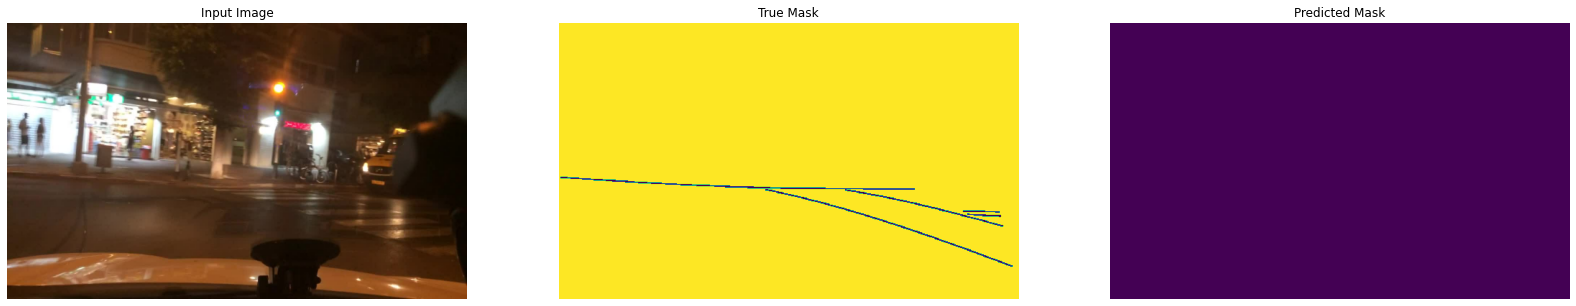

1/1 [==============================] - 0s 437ms/step


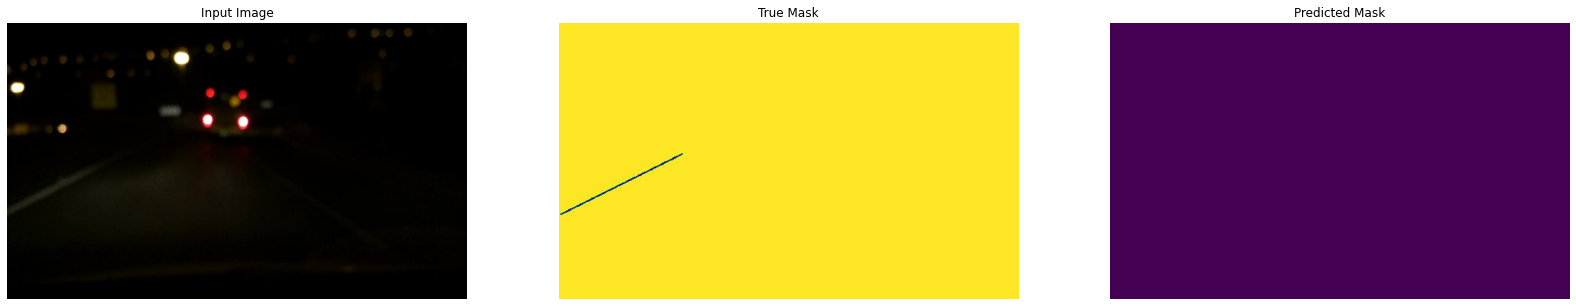

1/1 [==============================] - 0s 476ms/step


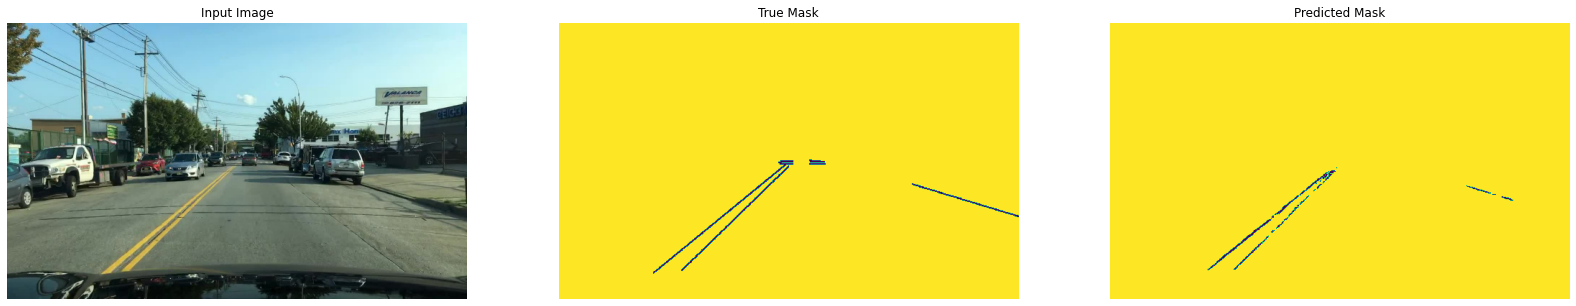

1/1 [==============================] - 1s 501ms/step


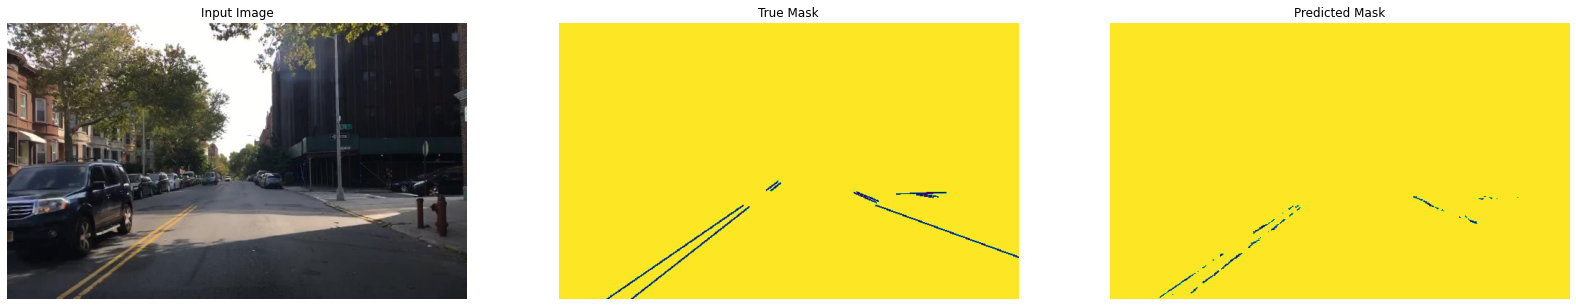

1/1 [==============================] - 0s 492ms/step


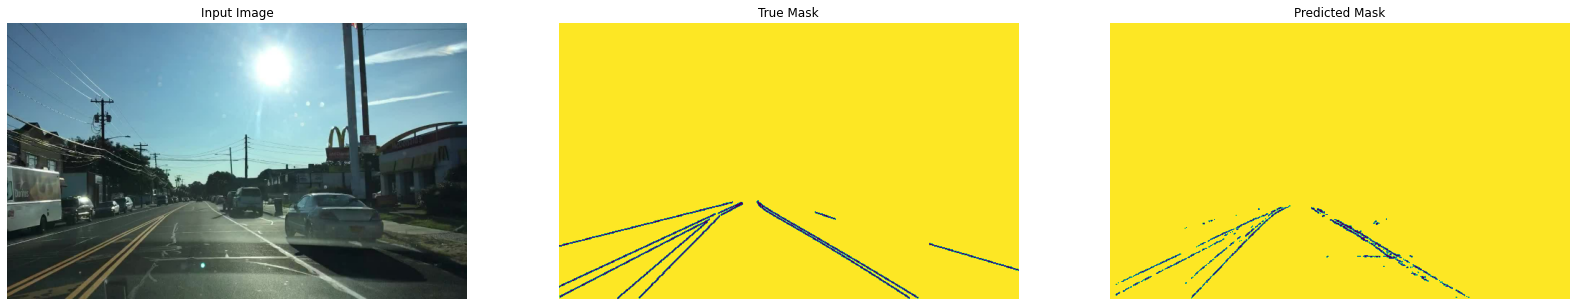

In [45]:
index = 0
for data in train_set:
  if index < 30:
    index += 1
    continue 

  dat_img = data[0] # dat_img.shape => (1, 368, 640, 3)
  original_mask = data[1] #  original_mask.shape => (1, 368, 640, 1)

  unbatched_img = dat_img[0] # shape => (368, 640, 3)
  unbatched_mask = original_mask[0] # shape => (368, 640, 1)

  # print("UNTRAINED MODEL")
  # display([unbatched_img, unbatched_mask, create_mask(untrained_model.predict(dat_img))])

  # print("TRAINED MODEL")
  display([unbatched_img, unbatched_mask, create_mask(trained_model.predict(dat_img))])

  if (index > 40):
    break

  index += 1

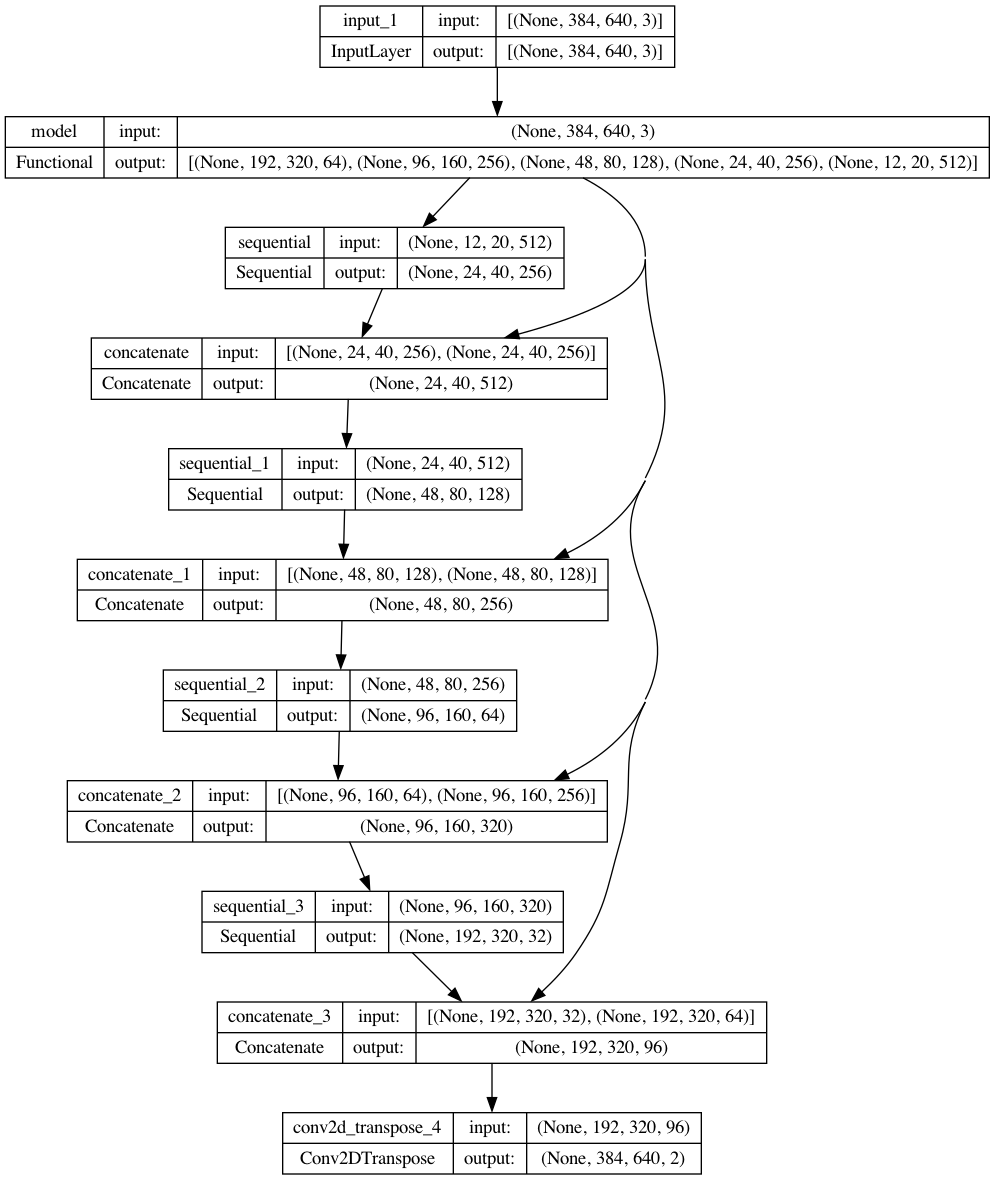

In [26]:

tf.keras.utils.plot_model(trained_model, show_shapes=True)

### Calling model.evaluate() on Datasets Partitions:

Train set evaluation: 
219/219 [==============================] - 146s 546ms/step - loss: 0.0276 - accuracy: 0.9906

Validation set evaluation: 
63/63 [==============================] - 46s 487ms/step - loss: 0.0309 - accuracy: 0.9905

test set evaluation: 
32/32 [==============================] - 28s 373ms/step - loss: 0.0298 - accuracy: 0.9908

## Using Plotting functions from evaluate.ipynb

In [60]:
import pickle
import model as model_file
import os
import matplotlib as mpl
import util
import model as model_file

def plot_loss_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
  plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  # plt.axis([1, 20, 0, 0.05])
  plt.legend(fontsize=14)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)

def plot_accuracy_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training Accuracy")
  plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation Accuracy")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  # plt.axis([1, 20, 0, 0.05])
  plt.legend(fontsize=14)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.grid(True)
  
def load_pkl_model_history(file_name):
  with open(file_name, "rb") as file_pi:
    history = pickle.load(file_pi)
  return history

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join("./", fig_id + "." + fig_extension)
  print("Saving figure", fig_id)
  if tight_layout:
      plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

In [53]:
history = load_pkl_model_history("model_d10_full_conv_history.pkl")

Saving figure model_d10_train_vs_val_loss


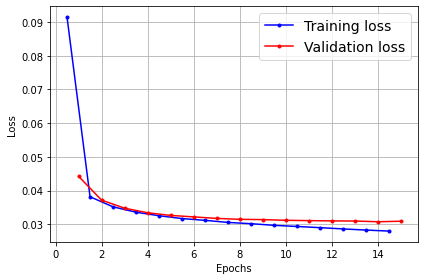

In [61]:
plot_loss_learning_curves(history["loss"], history["val_loss"])
save_fig("model_d10_train_vs_val_loss")
plt.show()

Saving figure model_d10_train_vs_val_acc


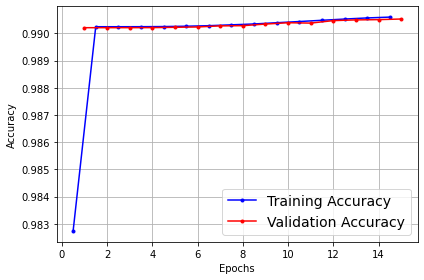

In [63]:
plot_accuracy_learning_curves(history["accuracy"], history["val_accuracy"])
save_fig("model_d10_train_vs_val_acc")
plt.show()

## New Metric Testing

In [63]:
predictions = []
labels = []
index = 0
for data in train_set:

  dat_img = data[0] # dat_img.shape => (1, 368, 640, 3)
  original_mask = data[1] #  original_mask.shape => (1, 368, 640, 1)

  unbatched_img = dat_img[0] # shape => (368, 640, 3)
  unbatched_mask = original_mask[0] # shape => (368, 640, 1)

  flattened_mask = np.array(unbatched_mask).flatten()
  pred_mask = create_mask(trained_model.predict(dat_img))
  flattened_pred_mask = np.array(pred_mask).flatten()

  predictions.append(flattened_pred_mask)
  labels.append(flattened_mask)

  if (index > 0):
    break

  index += 1

1/1 [==============================] - 0s 294ms/step


NOTE: These metrics are misleading since our labels are are lane lines have values of 1 and our non lane lines have values of zeros. It is likely that these scores should be be 1 - score??

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score

In [64]:
# average='samples'
# From sklearn docs: 
# Calculate metrics for each instance, and find their average 
# (only meaningful for multilabel classification where this differs 
# from accuracy_score).

recall = recall_score(labels, predictions, average='samples')
recall

0.9987242217497894

In [65]:
precision = precision_score(labels, predictions, average='samples')
precision

0.9837743850450911

In [66]:
f1_score(labels, predictions, average='samples')

0.9911716930545977